In [1]:
from collections import defaultdict
from itertools import groupby
import operator
import os
import re

import hdbscan
import numpy as np
import sklearn
import pandas as pd
import pickle
import random
import sparse
#import tensorly as tl
#import tensorly.decomposition as decomp
import sktensor
import umap
import urllib3
#import wget

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import logging
logging.basicConfig(level=logging.DEBUG, 
                    format='%(levelname)-8s [%(lineno)d] %(message)s')

if not os.path.exists('cp_orth.py'):
    wget.download('http://web.stanford.edu/~vsharan/cp_orth.py')
from cp_orth import orth_als

/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


In [7]:
class ClusterVerbs():
    def __init__(self, cutoff=2048, rank=50, prev_sep=True, min_cluster_size=5, min_samples=None, 
                 metric='cosine'):
        self.min_cluster_size = min_cluster_size
        self.min_samples = min_samples
        self.metric = metric
        self.verb_i = 1 + prev_sep
        tensor_dir = '/mnt/permanent/home/makrai/project/verb-tensor/{}'.format(
            'prev_sep' if prev_sep else 'sktensor')
        self.ktensor, _, _, _ = pickle.load(
            open(os.path.join(tensor_dir, 'decomp_{}_{}.pkl'.format(cutoff, rank)), mode='rb'))
        logging.debug(self.ktensor.shape)
        _, self.index = pickle.load(open(os.path.join(tensor_dir, 'tensor_{}.pkl'.format(cutoff)), mode='rb'))
        self.embed2 = self.do_umap(2)
        self.embed10 = self.do_umap(10)

    def do_umap(self, n_components):
        mapping = umap.UMAP(n_components=n_components, metric=self.metric)
        if self.ktensor.U[self.verb_i].shape[1] <= n_components:
            return self.ktensor.U[self.verb_i]
        return mapping.fit_transform(self.ktensor.U[self.verb_i])
    
    def do_cluster(self):
        clusser = hdbscan.HDBSCAN(min_cluster_size=self.min_cluster_size, min_samples=self.min_samples)
        # The implementation defaults min_samples to whatever min_cluster_size is set to
        self.labels = clusser.fit_predict(self.embed10)
        plt.scatter(self.embed2.T[0], self.embed2.T[1], c=self.labels, s=1)

    def show_clustering(self, n_clust_show=30, show_size_of=60, sort_sizes='descending', min_shown_size=3):
        assert sort_sizes in ['ascending', 'descending', 'rand']
        clus_len_l = [(key, len(list(group))) for key, group in groupby(sorted(self.labels))]
        if sort_sizes is not 'rand':
            clus_len_l = sorted(clus_len_l, key=operator.itemgetter(1), reverse=sort_sizes=='ascending')
        clusters, lens = zip(*list(clus_len_l))
        n_clusters = len(clus_len_l)
        #entropy_ = stats.entropy(lens)
        header = '{} clusters, entropy={:.2}, sizes: {}{}'.format(
            n_clusters, 'entropy_', ' '.join(map(str, lens[:show_size_of])), 
            '..' if n_clusters>show_size_of else '')
        print(header)
        verbs = np.array(list(self.index[self.verb_i].keys()))
        logging.info(verbs[:10])
        for cluster_i, clus_len in zip(clusters[:n_clust_show+1], lens):
            if clus_len < min_shown_size:# or cluster_i == -1:
                continue
            clus_siz = np.sum(self.labels==cluster_i)
            print('\n{} verbs. id: {}\n'.format(clus_siz, int(cluster_i)))
            print(verbs[self.labels==cluster_i])
        print('\n{}'.format(header))
    
    def main(self):
        self.do_cluster()
        self.show_clustering()

DEBUG    [12] (1251, 58, 898, 579)
INFO     [42] ['NULL' 'van' 'lesz' 'mond' 'tesz' 'tud' 'vesz' 'ad' 'tart' 'lát']
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos


31 clusters, entropy=en, sizes: 6 6 6 7 7 7 7 8 9 9 10 11 11 12 15 16 16 18 19 21 22 23 25 35 43 44 45 52 53 155 180

6 verbs. id: 8

['vigyáz' 'mosolyog' 'csodálkozik' 'bólint' 'legyint' 'bólogat']

6 verbs. id: 12

['kiált' 'bámul' 'szül' 'les' 'ordít' 'könyörög']

6 verbs. id: 29

['halad' 'mozog' 'fejlődik' 'erősöd' 'versenyez' 'küszködik']

7 verbs. id: 1

['jelent' 'elérik' 'követel' 'tervez' 'kíván' 'tapasztal' 'termel']

7 verbs. id: 11

['fekszik' 'csap' 'zárul' 'telepedik' 'fékez' 'ereszkedik' 'játszódik']

7 verbs. id: 20

['csatlakozik' 'tiltakozik' 'érdeklődik' 'viselkedik' 'reménykedik'
 'csalódik' 'kételkedik']

7 verbs. id: 28

['létez' 'létezik' 'bizonyul' 'érvényesül' 'vál' 'különbözik' 'megerősöd']

8 verbs. id: 4

['érkezik' 'találkozik' 'utazik' 'utaz' 'távozik' 'távoz' 'tartózkodik'
 'játsz']

9 verbs. id: 14

['születik' 'szerepel' 'utal' 'örül' 'lakik' 'emlékszik' 'emlékezik'
 'haragszik' 'gratulál']

9 verbs. id: 26

['nő' 'csökken' 'változik' 'emelkedik' 'növe

DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos


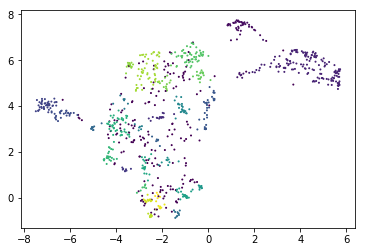

In [9]:
ClusterVerbs().main()

DEBUG    [12] (1251, 1293, 579)
INFO     [42] ['NULL' 'van' 'lesz' 'mond' 'tud' 'tesz' 'tart' 'lát' 'vesz' 'kerül']
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos


55 clusters, entropy=en, sizes: 5 5 6 6 6 6 6 7 7 8 8 8 8 10 10 10 11 11 11 12 12 12 12 12 12 12 13 14 14 15 15 15 15 15 15 16 16 17 17 18 19 21 22 23 24 25 25 26 26 26 29 30 33 40 476

5 verbs. id: 32

['kínál' 'szállít' 'előállít' 'behoz' 'bevet']

5 verbs. id: 52

['szán' 'szab' 'kitölt' 'meghosszabbít' 'igazít']

6 verbs. id: 0

['megfelel' 'számol' 'kitér' 'eltér' 'törekedik' 'kiindul']

6 verbs. id: 7

['megjelenik' 'keletkezik' 'hat' 'hangzik' 'terjed' 'szaporodik']

6 verbs. id: 17

['születik' 'létez' 'létezik' 'elkészül' 'megszületik' 'módosul']

6 verbs. id: 31

['oszt' 'süt' 'old' 'fúj' 'kiválik' 'gyújt']

6 verbs. id: 48

['elfog' 'eltávolít' 'aláz' 'elbocsát' 'kivégez' 'kihallgat']

7 verbs. id: 8

['benyújt' 'kidolgoz' 'terjeszt' 'bead' 'elvet' 'előterjeszt' 'beterjeszt']

7 verbs. id: 42

['menekül' 'hozzájut' 'megismerkedik' 'bukkan' 'bekapcsolódik' 'elválik'
 'megválik']

8 verbs. id: 5

['megvásárol' 'értékesít' 'eljuttat' 'beszerez' 'megtekint' 'továbbít'
 'lefoglal

DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos


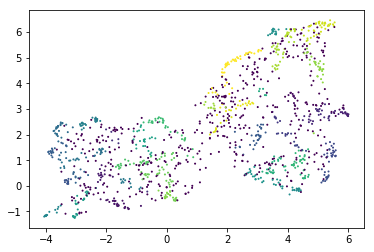

In [8]:
ClusterVerbs(prev_sep=False).main()